In [35]:
import os
from glob import glob

import numpy as np

import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers

import tensorflow_addons as tfa

In [36]:
!pip install tensorflow-addons


In [37]:
# check if everything is properly configured
print(f"GPU(s): {tf.config.list_physical_devices('GPU')}")
print(f"tensorflow version: {tf.__version__}")

GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tensorflow version: 2.15.0


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eliffiliz","key":"68f0b39246dc51654ff5b96323dfffe5"}'}

In [7]:
!cp kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [38]:
!kaggle datasets download -d ashishjangra27/gender-recognition-200k-images-celeba
!ls

Dataset URL: https://www.kaggle.com/datasets/ashishjangra27/gender-recognition-200k-images-celeba
License(s): CC-BY-NC-SA-4.0
 99% 1.30G/1.32G [00:22<00:00, 89.0MB/s]
100% 1.32G/1.32G [00:22<00:00, 62.1MB/s]
celeba					   kaggle.json	smile
gender-recognition-200k-images-celeba.zip  sample_data	smiling-or-not-face-data.zip


In [39]:
!cd /content
!mkdir ./celeba
!unzip /content/gender-recognition-200k-images-celeba.zip -d /content/celeba

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/celeba/Dataset/Validation/Male/189674.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189675.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189676.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189679.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189681.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189684.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189688.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189689.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189691.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189692.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189693.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189694.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189695.jpg  
  inflating: /content/celeba/Dataset/Validation/Male/189696.jpg  
  inflating: /content/celeba/

In [10]:
smile_path = '/content/smile/smile'
non_smile_path = '/content/smile/non_smile'

In [24]:
epochs = 50
batch_size = 16
w, h = 64, 64  # known by previously analizing images

In [25]:
smile_ds = image_dataset_from_directory(
    smile_path,
    labels=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(w, h),
    seed=42
)

non_smile_ds = image_dataset_from_directory(
    non_smile_path,
    labels=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(w, h),
    seed=42
)

Found 600 files belonging to 1 classes.
Found 603 files belonging to 1 classes.


In [26]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

In [27]:
smile_ds = smile_ds.map(normalize_img)
non_smile_ds = non_smile_ds.map(normalize_img)

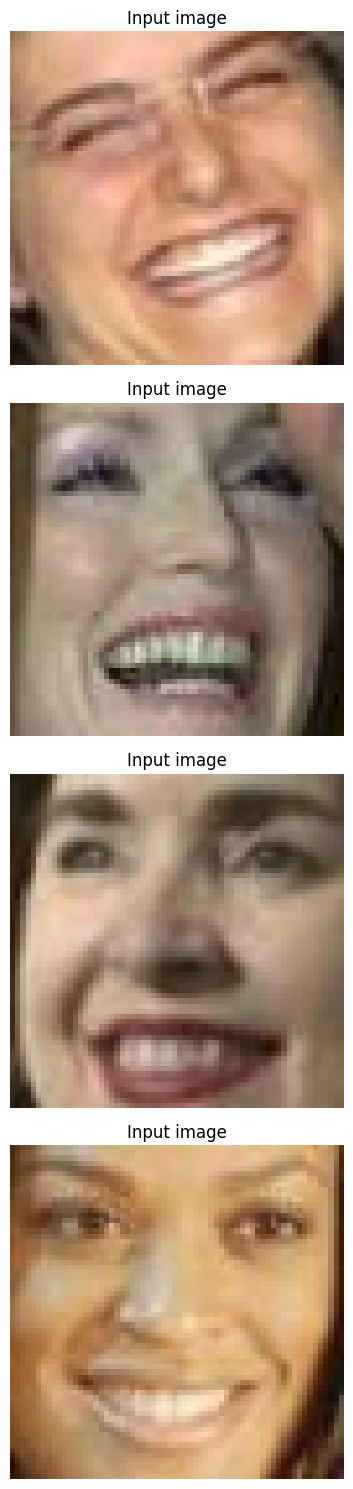

In [28]:
_, ax = plt.subplots(4, 1, figsize=(10, 15))
for i, img in enumerate(smile_ds.take(4)):
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i].imshow(img)
    ax[i].set_title("Input image")
    ax[i].set_title("Input image")
    ax[i].axis("off")

plt.tight_layout()
plt.show()

In [29]:
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
input_img_size = (64, 64, 3)


class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(
        self,
        padding=(1, 1),
        **kwargs
        ):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x

def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)


    num_filters = filters
    for num_downsample_block in range(num_downsampling):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model



class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()


    def train_step(self, batch_data):
        # x is non smile and y is smile
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # non smile to fake smile
            fake_y = self.gen_G(real_x, training=True)
            # smile to fake non smile -> y2x
            fake_x = self.gen_F(real_y, training=True)


            # Cycle (non smile to fake smile to fake non smile): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (smile to fake non smile to fake smile) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)


            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F


            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)

        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


In [30]:
# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [31]:
# Unhide cell output to view the generators and discriminators architecture.
# The output is very long so I've hidden it.

gen_G.summary(), gen_F.summary(), disc_X.summary(), disc_Y.summary()

Model: "generator_G"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 generator_G_img_input (Inp  [(None, 64, 64, 3)]          0         []                            
 utLayer)                                                                                         
                                                                                                  
 reflection_padding2d_80 (R  (None, 70, 70, 3)            0         ['generator_G_img_input[0][0]'
 eflectionPadding2D)                                                ]                             
                                                                                                  
 conv2d_108 (Conv2D)         (None, 64, 64, 64)           9408      ['reflection_padding2d_80[0][0
                                                                    ]']                 

(None, None, None, None)

In [32]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

In [33]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((non_smile_ds, smile_ds)),
    epochs=epochs
)

Epoch 1/50
38/38 [==============================] - 101s 751ms/step - G_loss: 4.9267 - F_loss: 4.9223 - D_X_loss: 0.2903 - D_Y_loss: 0.2821
Epoch 2/50
38/38 [==============================] - 25s 659ms/step - G_loss: 3.5177 - F_loss: 3.4968 - D_X_loss: 0.1719 - D_Y_loss: 0.1665
Epoch 3/50
38/38 [==============================] - 25s 652ms/step - G_loss: 3.3084 - F_loss: 3.2744 - D_X_loss: 0.2464 - D_Y_loss: 0.1833
Epoch 4/50
38/38 [==============================] - 25s 657ms/step - G_loss: 3.2972 - F_loss: 3.2481 - D_X_loss: 0.1975 - D_Y_loss: 0.1624
Epoch 5/50
38/38 [==============================] - 25s 661ms/step - G_loss: 3.2080 - F_loss: 3.3239 - D_X_loss: 0.1562 - D_Y_loss: 0.1824
Epoch 6/50
38/38 [==============================] - 25s 664ms/step - G_loss: 3.0472 - F_loss: 3.2655 - D_X_loss: 0.1698 - D_Y_loss: 0.2175
Epoch 7/50
38/38 [==============================] - 25s 653ms/step - G_loss: 3.0269 - F_loss: 3.2651 - D_X_loss: 0.1475 - D_Y_loss: 0.1948
Epoch 8/50
38/38 [========

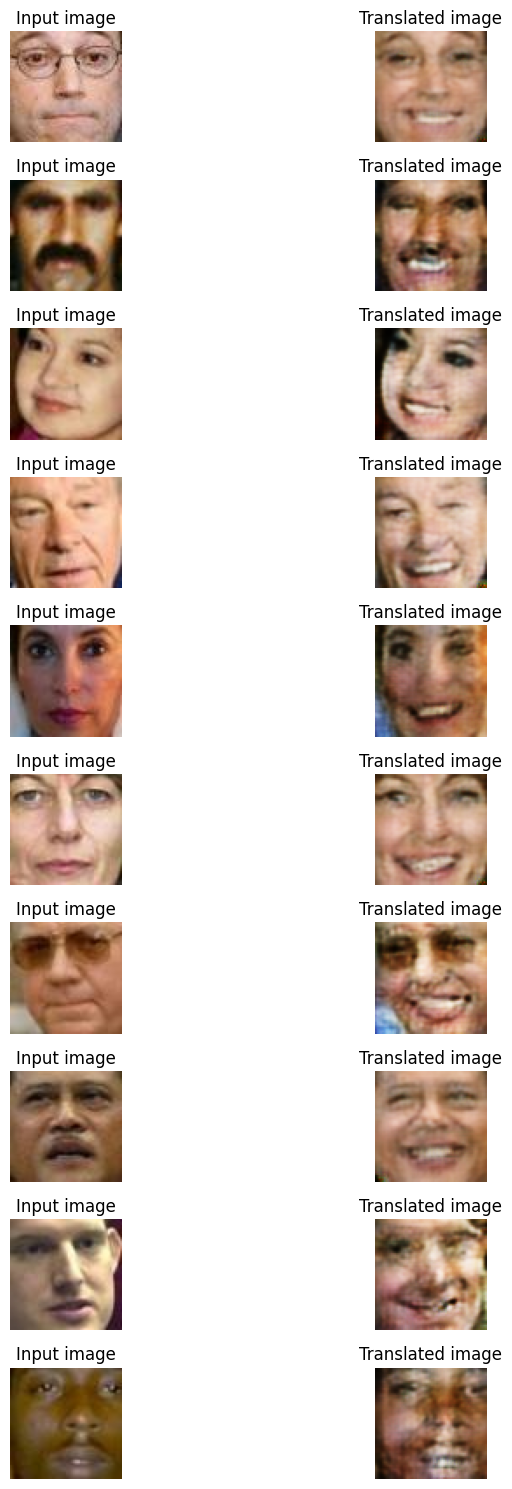

In [34]:
_, ax = plt.subplots(10, 2, figsize=(10, 15))
for i, img in enumerate(non_smile_ds.take(10)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    # prediction = keras.preprocessing.image.array_to_img(prediction)
    # prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()